# 14.06.2020 weekend research paper reading and implemention
- ### paper: [SRCNN](https://arxiv.org/pdf/1501.00092)
- ### implementation: pytorch
********

# libraries and configs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img_plt
import seaborn as sns
plt.style.use('dark_background')
from pathlib import *
import os
import re
import gc
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
print('imported necessarry libs')

ModuleNotFoundError: No module named 'pandas'

# data

In [2]:
class T91Set(torch.utils.data.Dataset):
    def __init__(self, image_dir, Y_size = 400, res_factor = 2.5, isTest = False):
        
        target_size = Y_size//res_factor
        self.isTest = isTest
        self.image_dir = image_dir
        self.Y_size = Y_size
        self.res_factor = res_factor
        self.target_size = target_size
        self.image_list = os.listdir(image_dir)
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop((self.Y_size, self.Y_size)),
            torchvision.transforms.ToTensor(),
        ])
        self.test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop((self.Y_size / self.res_factor, self.Y_size / self.res_factor)),
            torchvision.transforms.ToTensor(),
        ])
        self.PIL_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
        ])
        
    def __getitem__(self, index):
        
        if self.isTest:
            image_path = self.image_dir + str(self.image_list[index])
            image = Image.open(image_path)
            image, _, _ = image.convert('YCbCr').split()
            image = self.test_transforms(image)
            
            LR = self.PIL_transform(image)
            LR = LR.resize((self.Y_size, self.Y_size), Image.BICUBIC)
            LR = self.transforms(LR)
            return LR
        
        image_path = self.image_dir + str(self.image_list[index])
        image = Image.open(image_path)
        image, _, _ = image.convert('YCbCr').split()
        image = self.transforms(image)
        
        HR = image.clone()
        c, h, w = HR.shape
        
        LR = self.PIL_transform(image)
        LR = LR.resize((int(h // self.res_factor), int( w // self.res_factor)), Image.BICUBIC)
        LR = LR.resize((h, w), Image.BICUBIC)
        LR = self.transforms(LR)
        
        return torch.tensor(LR.numpy(), dtype = torch.float), torch.tensor(HR.numpy(), dtype = torch.float)
    
    def __len__(self):
        return len(self.image_list)

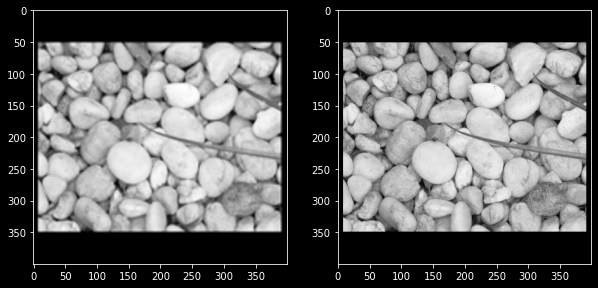

In [3]:
train_set = T91Set(
    image_dir='../input/t91-image-data/sris_srcnn_data/T91/',
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=4,
    shuffle=True,
    num_workers=4,
)

plt.rcParams['figure.figsize'] = [10, 5]
LRs, HRs = next(iter(train_loader))
smol, big = LRs[0], HRs[0]
plt.subplot(1, 2, 1)
plt.imshow(smol.squeeze(), cmap='Greys_r')
plt.subplot(1, 2, 2)
plt.imshow(big.squeeze(), cmap='Greys_r')

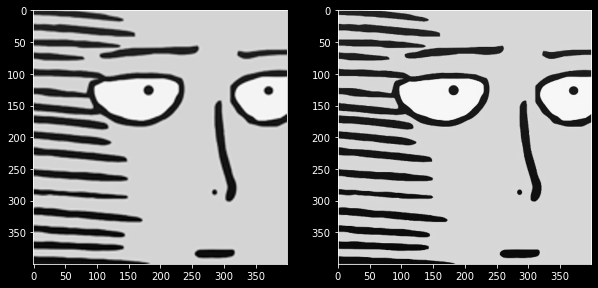

In [4]:
val_set = T91Set(
    image_dir='../input/t91-image-data/sris_srcnn_data/T91_val/',
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=1,
    shuffle=True,
    num_workers=4,
)

LRs, HRs = next(iter(val_loader))
smol, big = LRs, HRs
plt.subplot(1, 2, 1)
plt.imshow(smol.squeeze(), cmap='Greys_r')
plt.subplot(1, 2, 2)
plt.imshow(big.squeeze(), cmap='Greys_r')

torch.Size([1, 1, 400, 400])


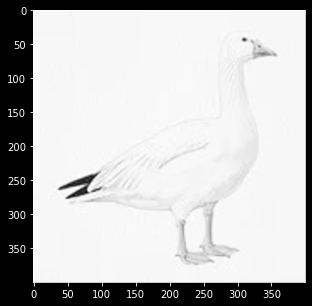

In [5]:
test_set = T91Set(
    image_dir='../input/t91-image-data/sris_srcnn_data/T91_test/',
    isTest=True,
)


test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=1,
    shuffle=True,
    num_workers=4,
)

LR = next(iter(test_loader))
print(LR.shape)
plt.imshow(LR.squeeze(), cmap='Greys_r')

# model definition

In [6]:
class SRCNN(nn.Module):
  def __init__(self, c, n1, n2, n3, f1, f2, f3):
    super(SRCNN, self).__init__()

    # patch extraction
    self.F1 = nn.Conv2d(in_channels=c,
                        out_channels=n1,
                        kernel_size=f1,
                        stride=1,
                        padding=4,                      
                        )
    
    # non-linear mapping
    self.F2 = nn.Conv2d(in_channels=n1,
                        out_channels=n2,
                        kernel_size=f2,
                        stride=1,
                        padding=1,       
                        )
    
    # reconstruction
    self.F3 = nn.Conv2d(in_channels=n2,
                        out_channels=n3,
                        kernel_size=f3,
                        stride=1,
                        padding=2,
                        )
    
  def forward(self, low_res_img):
    patches = F.relu(self.F1(low_res_img))
    mapping = F.relu(self.F2(patches))
    high_res = self.F3(mapping)

    return high_res

In [7]:
model = SRCNN(
    c=1,
    n1=64,
    n2=32,
    n3=1,
    f1=9,
    f2=3,
    f3=5,
)

# training 
- change validation set to kaggle profile photo only, overfit on that image 

In [8]:
def train(
    epochs,
    model,
    device,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    test_loader
):
    os.system('mkdir models')
    os.system('mkdir big_goose_pics')
    model = model.to(device)
    criterion = criterion.to(device)
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0

        model.train()
        for x, y in train_loader:
            # fetch the features and targets from train_loader
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            z = model(x)
    #             print(z.dtype)
    #             print(y.dtype)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            torch.cuda.empty_cache()

        # print validation image and model predictions 
        if epoch%50 == 0:
            with torch.no_grad():
                model.eval()
                
                for goose in test_loader:
                    goose = goose.to(device)                         # LR
                    big_goose = model(goose).detach().cpu().numpy()  # HR
                    print(big_goose.shape)
                    plt.imshow(big_goose.squeeze().squeeze(), cmap='Greys_r')
                    plt.show()
                print('=' * 20, 'EPOCH LOSS', epoch_loss, '=' * 20)
                torch.save(model.state_dict(), './models/ckpt_' + str(epoch) + '.pth')  
                img_plt.imsave('./big_goose_pics/big_goose_' + str(epoch) + '.png', big_goose.squeeze().squeeze(), cmap='Greys_r')              

  0%|          | 0/500 [00:00<?, ?it/s]

(1, 1, 400, 400)


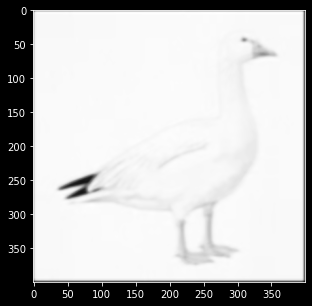

  0%|          | 1/500 [00:03<25:23,  3.05s/it]

==================== EPOCH LOSS 0.24384476314298809 ====================


 10%|█         | 50/500 [01:24<12:20,  1.64s/it]

(1, 1, 400, 400)


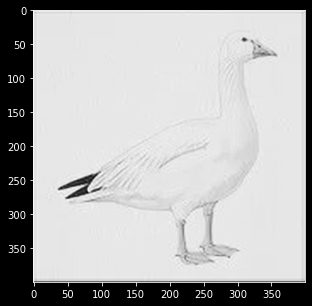

 10%|█         | 51/500 [01:26<13:12,  1.77s/it]

==================== EPOCH LOSS 0.01387399504892528 ====================


 20%|██        | 100/500 [02:52<11:42,  1.76s/it]

(1, 1, 400, 400)


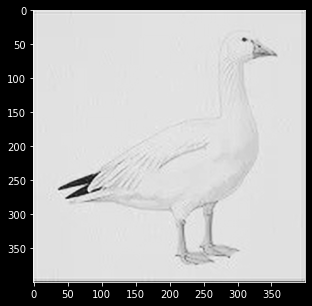

 20%|██        | 101/500 [02:54<12:10,  1.83s/it]

==================== EPOCH LOSS 0.013039722442044877 ====================


 30%|███       | 150/500 [04:15<09:34,  1.64s/it]

(1, 1, 400, 400)


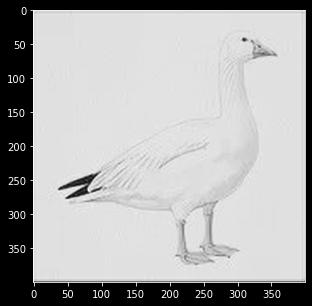

 30%|███       | 151/500 [04:17<10:15,  1.76s/it]

==================== EPOCH LOSS 0.013305917476827744 ====================


 40%|████      | 200/500 [05:38<08:10,  1.63s/it]

(1, 1, 400, 400)


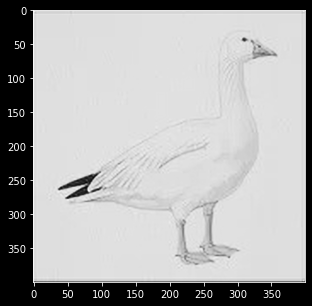

 40%|████      | 201/500 [05:40<08:38,  1.74s/it]

==================== EPOCH LOSS 0.012502779689384624 ====================


 50%|█████     | 250/500 [07:02<07:11,  1.73s/it]

(1, 1, 400, 400)


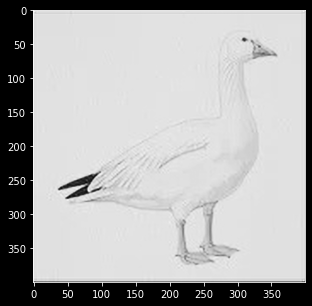

 50%|█████     | 251/500 [07:05<07:43,  1.86s/it]

==================== EPOCH LOSS 0.012278643422177993 ====================


 60%|██████    | 300/500 [08:27<05:26,  1.63s/it]

(1, 1, 400, 400)


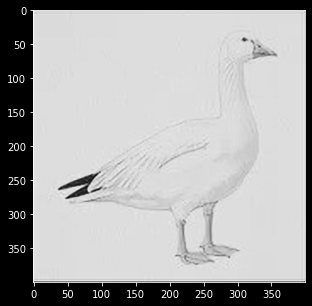

 60%|██████    | 301/500 [08:29<05:49,  1.76s/it]

==================== EPOCH LOSS 0.011956488007854205 ====================


 70%|███████   | 350/500 [09:51<04:23,  1.75s/it]

(1, 1, 400, 400)


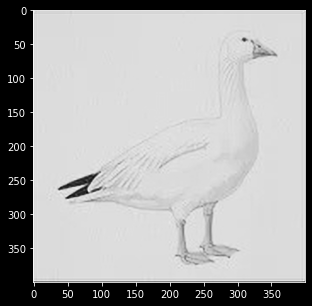

 70%|███████   | 351/500 [09:53<04:35,  1.85s/it]

==================== EPOCH LOSS 0.012388257964630611 ====================


 80%|████████  | 400/500 [11:15<02:44,  1.64s/it]

(1, 1, 400, 400)


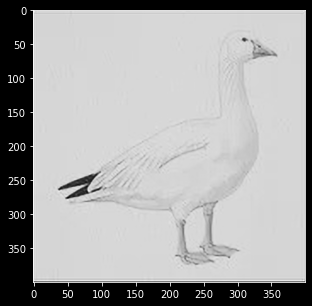

 80%|████████  | 401/500 [11:17<02:57,  1.80s/it]

==================== EPOCH LOSS 0.011690122315485496 ====================


 90%|█████████ | 450/500 [12:38<01:20,  1.61s/it]

(1, 1, 400, 400)


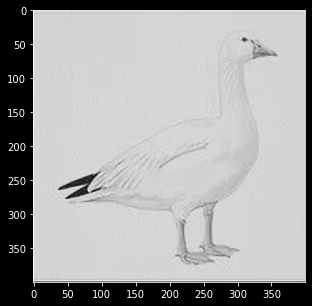

 90%|█████████ | 451/500 [12:40<01:24,  1.72s/it]

==================== EPOCH LOSS 0.011793088728154544 ====================


100%|██████████| 500/500 [14:25<00:00,  1.73s/it]


In [9]:
optimizer = torch.optim.Adam(model.parameters())
train(
    epochs=500,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion = nn.MSELoss(),
    optimizer=optimizer,
)